In [7]:
import cv2
import mediapipe as mp
import numpy as np

def preprocess_for_yolo(image_path, output_path=None, resize_size=(640, 640), padding=40):
    image = cv2.imread(image_path)
    if image is None:
        print("Không đọc được ảnh:", image_path)
        return None

    h, w, _ = image.shape
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # ======= Init MediaPipe =======
    mp_face_mesh = mp.solutions.face_mesh
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh, \
         mp_selfie_segmentation.SelfieSegmentation(model_selection=1) as selfie_seg:

        face_results = face_mesh.process(img_rgb)
        if not face_results.multi_face_landmarks:
            print("Không phát hiện khuôn mặt.")
            return None

        landmarks = face_results.multi_face_landmarks[0]

        # --- Contour viền mặt ---
        face_contour = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397,
                        365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172,
                        58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109]
        face_points = np.array([[int(landmarks.landmark[i].x * w),
                                 int(landmarks.landmark[i].y * h)]
                                for i in face_contour], dtype=np.int32)

        # --- Mask mặt ---
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(mask, [face_points], 255)

        # --- Xóa vùng mắt + miệng ---
        regions = {
            "left_eye": [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7],
            "right_eye": [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382],
            "mouth": [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 375, 321, 405, 314,
                      17, 84, 181, 91, 146, 61]
        }
        for region in regions.values():
            pts = np.array([[int(landmarks.landmark[i].x * w),
                             int(landmarks.landmark[i].y * h)]
                            for i in region], dtype=np.int32)
            cv2.fillPoly(mask, [pts], 0)

        # --- Segment để loại nền ---
        seg = selfie_seg.process(img_rgb)
        seg_mask = (seg.segmentation_mask > 0.9).astype(np.uint8) * 255
        seg_mask = cv2.GaussianBlur(seg_mask, (7, 7), sigmaX=3)
        seg_mask = (seg_mask > 127).astype(np.uint8) * 255

        comb_mask = cv2.bitwise_and(mask, seg_mask)
        masked = cv2.bitwise_and(img_rgb, img_rgb, mask=comb_mask)

        # --- Nền xám ---
        gray_bg = np.full_like(img_rgb, fill_value=180)
        img_with_gray_bg = np.where(comb_mask[:, :, None] == 255, masked, gray_bg)

        # --- Crop với padding ---
        x0, y0 = face_points.min(axis=0)
        x1, y1 = face_points.max(axis=0)
        x0 = max(x0 - padding, 0)
        y0 = max(y0 - padding, 0)
        x1 = min(x1 + padding, w)
        y1 = min(y1 + padding, h)
        face_crop = img_with_gray_bg[y0:y1, x0:x1]

        if face_crop.size == 0:
            print("Lỗi crop khuôn mặt.")
            return None

        # --- Resize về 640x640 ---
        resized_face = cv2.resize(face_crop, resize_size)

        # --- Lưu nếu cần ---
        if output_path:
            cv2.imwrite(output_path, cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR))
            print(f" Đã lưu: {output_path}")

        return resized_face


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load model YOLO
model = YOLO("D:/KLTN/FINAL_SKINTONE/runs/detect/cheek_chin_yolov8_skin/weights/best.pt")

def run_yolo_and_display(image_np):
    # Chạy YOLO
    results = model(image_np, conf=0.1)[0]

    # Copy ảnh để vẽ
    result_img = image_np.copy()
    crops = []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = int(box.cls[0])
        conf = float(box.conf[0])
        
        # Vẽ bounding box
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(result_img, f"{model.names[label]} {conf:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Crop vùng dự đoán
        crop = image_np[y1:y2, x1:x2]
        crops.append(crop)

    # Hiển thị ảnh có bounding box
    plt.figure(figsize=(8, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title("YOLO Detection")
    plt.show()

    # Hiển thị từng vùng crop
    for i, crop in enumerate(crops):
        plt.figure()
        plt.imshow(crop)
        plt.axis('off')
        plt.title(f"Crop {i+1}")
        plt.show()

    return result_img, crops


 Đã lưu: D:/KLTN/FINAL_SKINTONE/pre_processing/processed.jpg


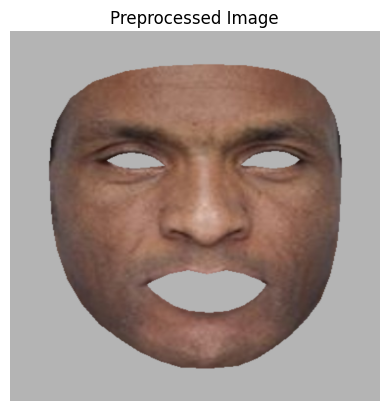


0: 640x640 2 lefts, 88.5ms
Speed: 5.8ms preprocess, 88.5ms inference, 105.5ms postprocess per image at shape (1, 3, 640, 640)


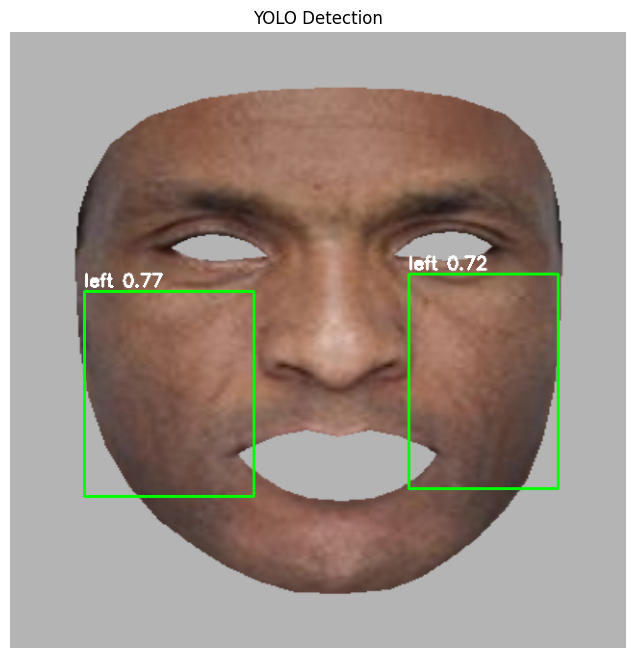

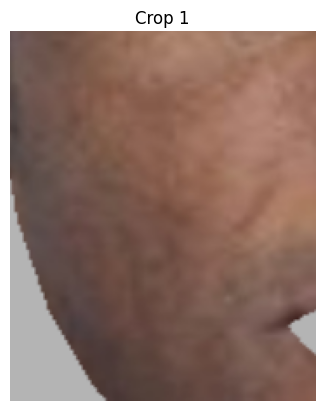

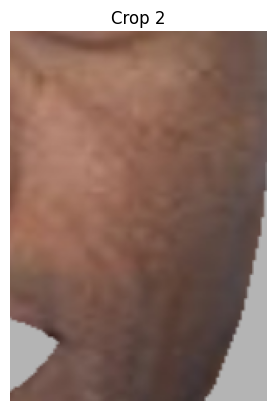

In [18]:
# ======= ĐƯỜNG DẪN ẢNH =======
input_path = "D:/KLTN/FINAL_SKINTONE/public/data_skintone/dark/1c9d3c83de5cc20c534a7f0d3f6b1541.jpg"
output_path = "D:/KLTN/FINAL_SKINTONE/pre_processing/processed.jpg"

# ======= TIỀN XỬ LÝ ẢNH =======
processed_image = preprocess_for_yolo(input_path, output_path)

# ======= HIỂN THỊ ẢNH TIỀN XỬ LÝ =======
import matplotlib.pyplot as plt

if processed_image is not None:
    plt.imshow(processed_image)
    plt.axis('off')
    plt.title("Preprocessed Image")
    plt.show()
else:
    print("Không có ảnh sau tiền xử lý.")

# === Gọi YOLO và hiển thị kết quả ===
if processed_image is not None:
    result_img, crops = run_yolo_and_display(processed_image)
else:
    print("Ảnh đầu vào không hợp lệ.")